In [2]:
import numpy as np
import h5py
import pandas as pd
from glob import glob
import os
import re
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm, Normalize
# settings
plt.style.use("fivethirtyeight")

import PyBlastAfterglowMag as PBA
from ejecta import ProcessRaw
from settings import *

df = SIMS[SIMS["given_time"] == "new"]

color_pal = sns.color_palette(n_colors=len(df))

np.set_printoptions(precision=2)

figs = os.getcwd()+"/figs/"
pdfs = "/home/vsevolod/Work/GIT/overleaf/kenta/figs/"

In [3]:
# Collate data for simulations (USE ONLY ONCE)\
for sim_key, sim_dic in SIMS.items():
    pr = ProcessRaw(simumlation=sim_dic)
    #pr.process_raw_ejecta_files(infiles= "ejecta_*.h5", fname_output= "ej_collated.h5", mode="mass",overwrite=False)
    #pr.process_raw_ejecta_files(infiles="Mdot_ejecta_*.h5", fname_output="mdot_ej_collated.h5", mode="mdot",overwrite=False)

In [25]:
# collect tmin tmax for all simulations
df["tmin"],df["tmax"] = pd.Series(dtype = 'object'), pd.Series(dtype = 'object')
data = None
for sim, sim_dic in df.iterrows():
    data = PBA.id_kenta.EjectaData(sim_dic["datadir"]+"ej_collated.h5",verbose=True)
    df["tmin"][sim] = np.array(data.getText().min())
    df["tmax"][sim] = np.array(data.getText().max())
print(df[["idx","tmin","tmax"]])
print(data.dfile["time=14.5857"].keys())

                           idx                  tmin                tmax
SFHo_13_14_res150            1  0.028825554996728897   49.89703369140625
SFHo_12_15_res150_B15_HLLD   6    12.193209648132324  30.987470626831055
BHBLp_135_135_res150         7  0.057651109993457794   40.98994064331055
<KeysViewHDF5 ['entr', 'eps', 'mass', 'press', 'rho', 'temp', 'ye']>


/tmp/ipykernel_18262/3201963958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tmin"],df["tmax"] = pd.Series(dtype = 'object'), pd.Series(dtype = 'object')
/tmp/ipykernel_18262/3201963958.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tmin"][sim] = np.array(data.getText().min())
/tmp/ipykernel_18262/3201963958.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

3


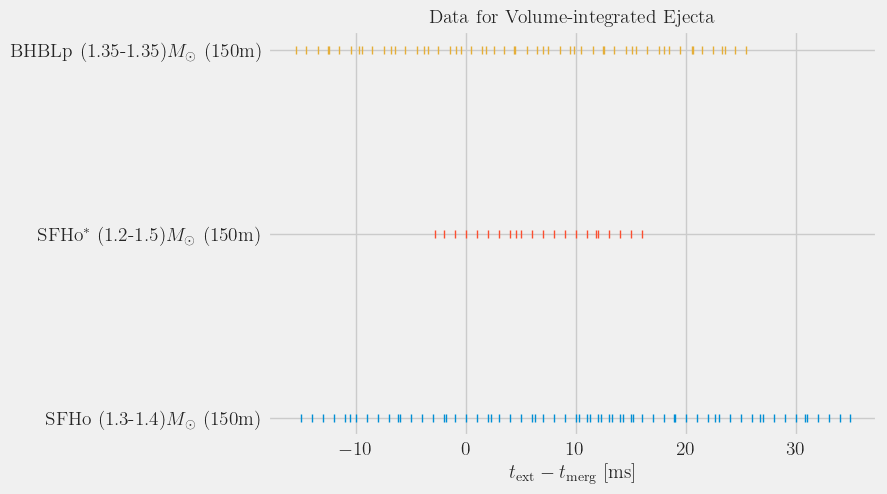

In [8]:
# Plot extraction time for all simulations
fig, ax = plt.subplots(figsize=(7,5))
print(len(color_pal))
for idx, sim_dic in enumerate(df.iterrows()):
    sim_dic = sim_dic[1]
    data = PBA.id_kenta.EjectaData(sim_dic["datadir"]+"ej_collated.h5",verbose=True)
    tmerg = sim_dic["tmerg"]
    ax.plot(data.getText()-tmerg, np.full_like(data.getText(), int(idx)),  marker="|", color=color_pal[idx], linestyle="None")
ax.set_yticks(np.arange(len(df)))
ticks_loc = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_yticklabels(df["label"].to_list(),fontsize=14)
ax.set_xlabel(r"$t_{\rm ext} - t_{\rm merg}$ [ms]", fontsize=14)
ax.tick_params(labelsize=14)
ax.minorticks_on()
ax.set_title("Data for Volume-integrated Ejecta",fontsize=14)
plt.show()

In [59]:
def get_vave_theta_rms(sim_dic:dict, crit:str) -> pd.DataFrame:
    vals = {"vave":[], "ye_ave":[], "theta_rms":[], "entr_ave":[],"eps_ave":[],"temp_ave":[], "time":[], "mass":[]}
    
    ej = PBA.id_kenta.EjectaData(sim_dic["datadir"]+"ej_collated.h5",verbose=True)
    
    for it, text in enumerate(ej.getText()):
        ej_mass = ej.get(v_n="mass",text=text)       
        
        mask = ej.get_vinf_mask(crit=crit)

        vals["mass"].append( np.sum(ej_mass[:,mask]) )
        
        ej_vinf = ej.get_vinf()
        vals["vave"].append( np.sum(ej_mass[:,mask]*ej_vinf[mask])/np.sum(ej_mass[:,mask]) )
        
        for v_n in ["ye","entr","eps","temp"]:
            ave = ej.get(v_n=v_n,text=text)
            vals[f"{v_n}_ave"].append( np.sum(ej_mass[:,mask]*ave[:,mask])/np.sum(ej_mass[:,mask]) )
    
        thetas = ej.get_theta()
        vals["theta_rms"].append( (180. / np.pi) * np.sqrt(np.sum(np.sum(ej_mass[:,mask], axis=1) * thetas ** 2) / np.sum(ej_mass[:,mask])) )
    # vals = {key:np.array(vals) for (key,val) in vals.items()}


    tmerg = sim_dic["tmerg"]
    times = ej.getText()
    vals["time"] = times - tmerg
    
    return pd.DataFrame.from_dict(vals)
    

In [60]:
def print_table(crit:str="fast") -> pd.DataFrame:
    df_res = {sim_dic["label"] : {} for _, sim_dic in df.iterrows()}
    for idx, sim_dic in enumerate(df.iterrows()):
        
        sim_dic = sim_dic[1]
        df_ave = get_vave_theta_rms(sim_dic=sim_dic, crit=crit)
        idx = df_ave["mass"].argmax()
        
        df_res[sim_dic["label"]]["text"] = df_ave["time"][idx]
        df_res[sim_dic["label"]]["mass"] = df_ave["mass"][idx]
        df_res[sim_dic["label"]]["vave"] = df_ave["vave"][idx]
        df_res[sim_dic["label"]]["ye_ave"] = df_ave["ye_ave"][idx]
        df_res[sim_dic["label"]]["eps_ave"] = df_ave["eps_ave"][idx]
        df_res[sim_dic["label"]]["temp_ave"] = df_ave["temp_ave"][idx]
        df_res[sim_dic["label"]]["theta_rms"] = df_ave["theta_rms"][idx]
    df_res = pd.DataFrame.from_dict(df_res).T
    return df_res
print("-------------- EJECTA ----------------- ")
print_table(crit=None)

-------------- EJECTA ----------------- 


/tmp/ipykernel_18262/1994580090.py:14: RuntimeWarning: invalid value encountered in double_scalars
  vals["vave"].append( np.sum(ej_mass[:,mask]*ej_vinf[mask])/np.sum(ej_mass[:,mask]) )
/tmp/ipykernel_18262/1994580090.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vals[f"{v_n}_ave"].append( np.sum(ej_mass[:,mask]*ave[:,mask])/np.sum(ej_mass[:,mask]) )
/tmp/ipykernel_18262/1994580090.py:21: RuntimeWarning: invalid value encountered in double_scalars
  vals["theta_rms"].append( (180. / np.pi) * np.sqrt(np.sum(np.sum(ej_mass[:,mask], axis=1) * thetas ** 2) / np.sum(ej_mass[:,mask])) )


,text,mass,vave,ye_ave,eps_ave,temp_ave,theta_rms
SFHo (1.3-1.4)$M_{\odot}$ (150m),34.897034,0.004406,0.198499,0.296041,9.106276e+20,1.072113e+09,64.823170
SFHo$^*$ (1.2-1.5)$M_{\odot}$ (150m),15.987471,0.001905,0.194033,0.221006,9.037609e+20,9.262238e+08,70.488412
BHBLp (1.35-1.35)$M_{\odot}$ (150m),25.489941,0.002381,0.142974,0.292206,9.019553e+20,1.525798e+09,65.970666


In [61]:
print("-------------- Fast Tail ----------------- ")
print_table(crit="fast")

-------------- Fast Tail ----------------- 


/home/vsevolod/anaconda3/envs/PyBlastAfterglow/lib/python3.9/site-packages/PyBlastAfterglowMag/utils.py:51: RuntimeWarning: invalid value encountered in sqrt
  get_Gamma = lambda beta: np.float64(np.sqrt(1. / (1. - np.float64(beta) ** 2.)))
/tmp/ipykernel_18262/1994580090.py:14: RuntimeWarning: invalid value encountered in double_scalars
  vals["vave"].append( np.sum(ej_mass[:,mask]*ej_vinf[mask])/np.sum(ej_mass[:,mask]) )
/tmp/ipykernel_18262/1994580090.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vals[f"{v_n}_ave"].append( np.sum(ej_mass[:,mask]*ave[:,mask])/np.sum(ej_mass[:,mask]) )
/tmp/ipykernel_18262/1994580090.py:21: RuntimeWarning: invalid value encountered in double_scalars
  vals["theta_rms"].append( (180. / np.pi) * np.sqrt(np.sum(np.sum(ej_mass[:,mask], axis=1) * thetas ** 2) / np.sum(ej_mass[:,mask])) )


,text,mass,vave,ye_ave,eps_ave,temp_ave,theta_rms
SFHo (1.3-1.4)$M_{\odot}$ (150m),26.018764,2.010213e-06,0.742781,0.305948,9.813487e+20,2.975952e+08,62.059510
SFHo$^*$ (1.2-1.5)$M_{\odot}$ (150m),15.987471,6.596214e-07,0.745250,0.286977,9.718702e+20,4.247296e+08,67.556995
BHBLp (1.35-1.35)$M_{\odot}$ (150m),13.498508,8.179031e-08,0.727849,0.326317,9.851060e+20,4.603811e+08,60.464015


/tmp/ipykernel_18262/1994580090.py:14: RuntimeWarning: invalid value encountered in double_scalars
  vals["vave"].append( np.sum(ej_mass[:,mask]*ej_vinf[mask])/np.sum(ej_mass[:,mask]) )
/tmp/ipykernel_18262/1994580090.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vals[f"{v_n}_ave"].append( np.sum(ej_mass[:,mask]*ave[:,mask])/np.sum(ej_mass[:,mask]) )
/tmp/ipykernel_18262/1994580090.py:21: RuntimeWarning: invalid value encountered in double_scalars
  vals["theta_rms"].append( (180. / np.pi) * np.sqrt(np.sum(np.sum(ej_mass[:,mask], axis=1) * thetas ** 2) / np.sum(ej_mass[:,mask])) )


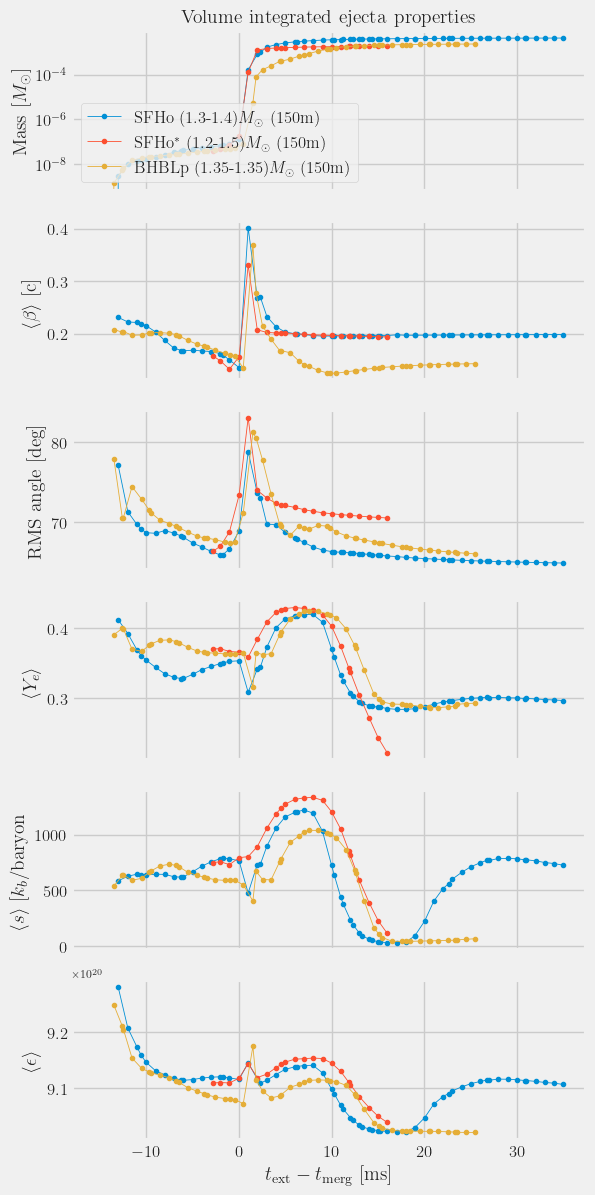

In [66]:
# Ejecta mass evolution of all simulation
def plot_all_sim_ejecta_mass(crit=None,yscale="linear",ylim=(0,0.04),title="Volume integrated ejecta mass"):
    fig, ax = plt.subplots(ncols=1,nrows=1)
    #ax2 = ax.twinx()
    for idx, sim_dic in enumerate(df.iterrows()):
        sim_dic = sim_dic[1]
        ej = PBA.id_kenta.EjectaData(sim_dic["datadir"]+"ej_collated.h5",verbose=True)
        if (crit is None):
            mass = ej.total_mass()
        else:
            mass = ej.total_mass_vs_text(crit=crit)

        if sim_dic["given_time"] == "new":
            ax.plot(ej.getText(), mass, color=color_pal[idx],
                label=sim_dic["label"],ls="-")
        else:
            ax.plot(ej.getText(), mass, color=color_pal[idx],
                label=sim_dic["label"],ls=":")
        # data = PBA.id_kenta.Data(fpath_rhomax=sim_dic["datadir"]+sim_dic["rhomax"],
        #                          fpath_mdot=sim_dic["datadir"]+sim_dic["mdot_extract"])
        # ax.plot(ej.getText(), ej.total_mass_fasttail(),color=color_pal[sim_dic["idx"]],
        #         label=r"$\Gamma\beta>1$",ls="--")
        # ax2.plot(*data.get_rhomax(),color=color_pal[sim_dic["idx"]],label=r"$\rho_{\rm max}$",ls=":")
        # ax2.plot(*data.get_mdot(),color=color_pal[sim_dic["idx"]],label=r"$\dot{M}$",ls="-.")
    ax.tick_params(labelsize=12)
    ax.set_ylim(*ylim)
    ax.set_yscale(yscale)
    ax.legend(fontsize=12,ncol=2)
    # ax.set_yscale("log")
    ax.set_xlabel("Extraction time [ms]",fontsize=14)
    ax.set_ylabel(r"Ejecta mass $[M_{\odot}]$",fontsize=14)
    ax.set_title(title,fontsize=14)
    # ax.grid(which="both",axis="both")
    plt.tight_layout()
    plt.savefig(figs+"ejecta_mass_evol.png",dpi=256)
    plt.show()
def plot_all_sim_ejecta_massave_vel(crit=None,yscale="linear",ylim=(0,0.04),title="Volume integrated ejecta mass",
                                    figfpath:str="mej_vej_theta.png"):
    fig, ax = plt.subplots(ncols=1,nrows=6,sharex="all",figsize=(6,12))
    #ax2 = ax.twinx()
    for idx, sim_dic in enumerate(df.iterrows()):
        sim_dic = sim_dic[1]

        df_ave = get_vave_theta_rms(sim_dic=sim_dic, crit=crit)

        ax[0].plot(df_ave["time"], df_ave["mass"], color=color_pal[idx], label=sim_dic["label"],marker='.', lw=.6)

        # ---

        ax[1].plot(df_ave["time"], df_ave["vave"], color=color_pal[idx], marker='.', lw=.6)
        ax[2].plot(df_ave["time"], df_ave["theta_rms"], color=color_pal[idx], marker='.', lw=.6)
        ax[3].plot(df_ave["time"], df_ave["ye_ave"], color=color_pal[idx], marker='.', lw=.6)
        ax[4].plot(df_ave["time"], df_ave["entr_ave"], color=color_pal[idx], marker='.', lw=.6)
        ax[5].plot(df_ave["time"], df_ave["eps_ave"], color=color_pal[idx], marker='.', lw=.6)
      
        

    for _ax in ax:
        _ax.tick_params(labelsize=12)
        _ax.minorticks_on()
    # ax[0].set_ylim(*ylim)
    ax[0].set_yscale(yscale)
    ax[0].legend(fontsize=12,ncol=1,loc="lower left")
    ax[0].set_yscale("log")
    #ax[5].set_yscale("log")
    # ax[-1].set_xlabel("Extraction time [ms]",fontsize=14)
    ax[-1].set_xlabel(r"$t_{\rm ext} - t_{\rm merg}$ [ms]", fontsize=14)
    ax[0].set_ylabel(r"Mass [$M_{\odot}$]",fontsize=14)
    ax[1].set_ylabel(r"$\langle\beta\rangle$ [c]",fontsize=14)
    ax[2].set_ylabel(r"RMS angle [deg]",fontsize=14)
    ax[3].set_ylabel(r"$\langle Y_e \rangle$",fontsize=14)
    ax[4].set_ylabel(r"$\langle s \rangle$ [$k_b/$baryon",fontsize=14)
    ax[5].set_ylabel(r"$\langle \epsilon \rangle$",fontsize=14)
    ax[0].set_title(title,fontsize=14)
    # ax.grid(which="both",axis="both")
    plt.tight_layout()
    plt.savefig(figs+figfpath,dpi=512)
    plt.savefig(pdfs+figfpath.replace(".png",".pdf"))
    plt.show()
# plot_all_sim_ejecta_mass(ylim=(0,0.01))
plot_all_sim_ejecta_massave_vel(ylim=(0., 0.01),
                                title="Volume integrated ejecta properties",
                                figfpath="mej_vej_theta.png")

/home/vsevolod/anaconda3/envs/PyBlastAfterglow/lib/python3.9/site-packages/PyBlastAfterglowMag/utils.py:51: RuntimeWarning: invalid value encountered in sqrt
  get_Gamma = lambda beta: np.float64(np.sqrt(1. / (1. - np.float64(beta) ** 2.)))
/tmp/ipykernel_18262/1994580090.py:14: RuntimeWarning: invalid value encountered in double_scalars
  vals["vave"].append( np.sum(ej_mass[:,mask]*ej_vinf[mask])/np.sum(ej_mass[:,mask]) )
/tmp/ipykernel_18262/1994580090.py:18: RuntimeWarning: invalid value encountered in double_scalars
  vals[f"{v_n}_ave"].append( np.sum(ej_mass[:,mask]*ave[:,mask])/np.sum(ej_mass[:,mask]) )
/tmp/ipykernel_18262/1994580090.py:21: RuntimeWarning: invalid value encountered in double_scalars
  vals["theta_rms"].append( (180. / np.pi) * np.sqrt(np.sum(np.sum(ej_mass[:,mask], axis=1) * thetas ** 2) / np.sum(ej_mass[:,mask])) )


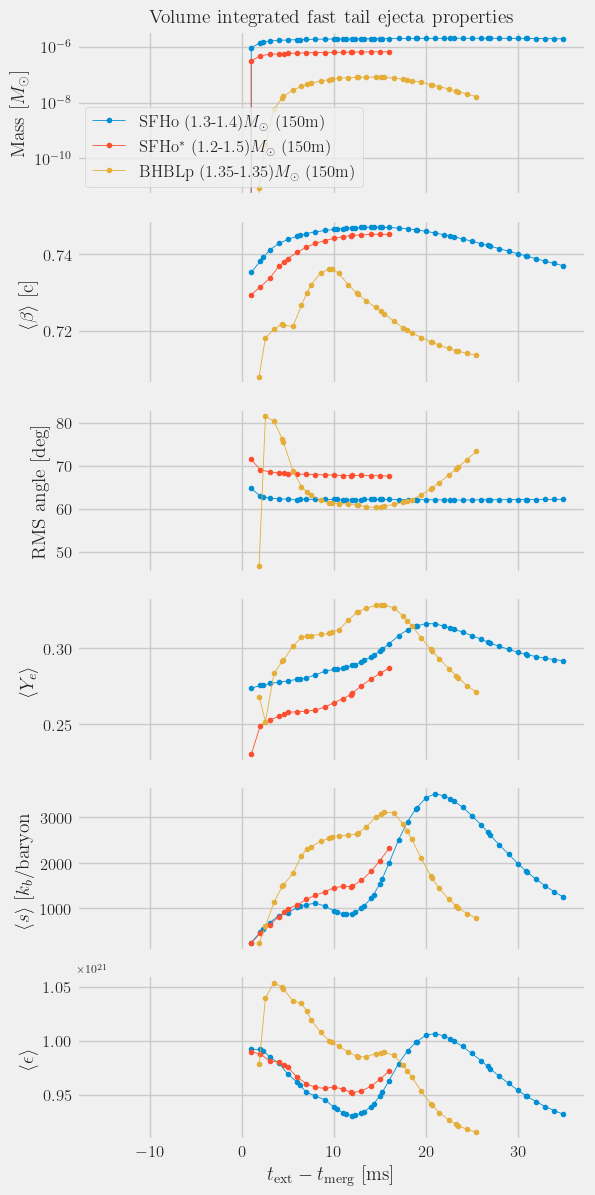

In [67]:

# Ejecta mass fast tail evolution of all simulations
# plot_all_sim_ejecta_mass(crit="fast",yscale="log",ylim=(1e-8,1e-5),
#                          title="Volume integrated fast tail ejecta mass")
plot_all_sim_ejecta_massave_vel(
    crit="fast",yscale="log",ylim=(1e-7,1e-5),
    title="Volume integrated fast tail ejecta properties",
    figfpath="mej_vej_theta_fasttail.png"
)

# ONE SIMULATION

In [16]:
##sim_dic = SIMULATIONS["BHBLp_135_135_res150"]
#sim_dic = SIMULATIONS["SFHo_12_15_res150_B15_HLLD"]
sim_dic_1 = SIMULATIONS["SFHo_13_14_res150"]
ej_data_1 = PBA.id_kenta.EjectaData(sim_dic_1["datadir"]+"ej_collated.h5",verbose=True)
data_1 = PBA.id_kenta.Data(fpath_rhomax=sim_dic_1["datadir"]+sim_dic_1["rhomax"],
                         fpath_mdot=sim_dic_1["datadir"]+sim_dic_1["mdot_extract"])

sim_dic_2 = SIMULATIONS["SFHo_12_15_res150_B15_HLLD"]
ej_data_2 = PBA.id_kenta.EjectaData(sim_dic_2["datadir"]+"ej_collated.h5",verbose=True)
data_2 = PBA.id_kenta.Data(fpath_rhomax=sim_dic_2["datadir"]+sim_dic_2["rhomax"],
                           fpath_mdot=sim_dic_2["datadir"]+sim_dic_2["mdot_extract"])


/home/vsevolod/anaconda3/envs/PyBlastAfterglow/lib/python3.9/site-packages/PyBlastAfterglowMag/utils.py:51: RuntimeWarning: invalid value encountered in sqrt
  get_Gamma = lambda beta: np.float64(np.sqrt(1. / (1. - np.float64(beta) ** 2.)))


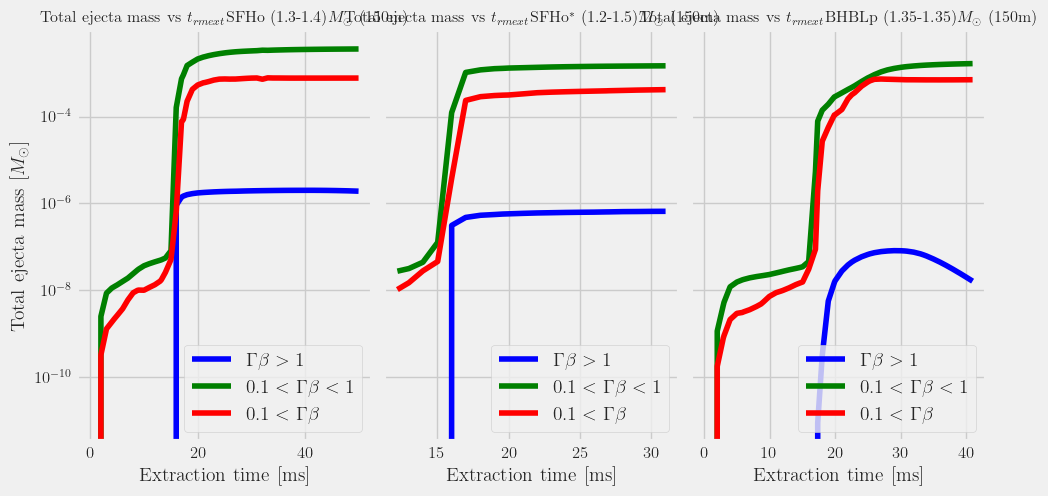

In [21]:
def plot_ejecta_mass_components_text(sim_dics:list[dict]):
    
    
    fig, axes = plt.subplots(ncols=len(sim_dics),nrows=1,sharey='all',figsize=(10,5))
    for i, sim_dic in enumerate(sim_dics):

        dd = PBA.id_kenta.EjectaData(sim_dic["datadir"] + "ej_collated.h5",verbose=True)
        ax = axes[i]
        ax.plot(dd.getText(),dd.total_mass_vs_text(crit="fast"),color="blue",label=r"$\Gamma\beta > 1$")
        ax.plot(dd.getText(),dd.total_mass_vs_text(crit="mid"),color="green",label=r"$0.1 < \Gamma\beta < 1$")
        ax.plot(dd.getText(),dd.total_mass_vs_text(crit="slow"),color="red",label=r"$0.1 < \Gamma\beta$")
        # ax.plot([text_max_mass],[max_mass],marker='d',color='blue')
    
        ax.tick_params(labelsize=12)
        # ax.set_ylim(0,0.04)
        ax.set_yscale("log")
        ax.legend(fontsize=14,ncol=1)
        # ax.set_yscale("linear")
        ax.set_xlabel("Extraction time [ms]",fontsize=14)
        ax.set_title(r"Total ejecta mass vs $t_{rm ext}$"+sim_dic["label"])
        # ax.grid(which="both",axis="both")
    axes[0].set_ylabel(r"Total ejecta mass $[M_{\odot}]$",fontsize=14)
    plt.tight_layout()
    plt.savefig(figs+f"mass_components.png",dpi=256)
plot_ejecta_mass_components_text(sim_dics=[SIMULATIONS["SFHo_13_14_res150"],
                                           SIMULATIONS["SFHo_12_15_res150_B15_HLLD"],
                                           SIMULATIONS["BHBLp_135_135_res150"]])
plt.show()
# plot_ejecta_mass_components_text(dd=ej_data)

In [95]:
# plot one simulation
#df = pd.merge(data.df_mdot,data.df_rho,how="left",on="time")

# for key, series in data.df_mdot.items():
#     if (np.sum((series == 0).astype(int)) == len(series)):
#         print(f"{key} \t zeroes n={np.sum((series == 0).astype(int))}/{len(series)}")
#     if (np.sum((series == 0).astype(int)) > len(series)*.5):
#         print(f"{key} \t zeroes n={np.sum((series == 0).astype(int))}/{len(series)}")

#print(data.df_mdot.keys())
#print(data.df_rho.keys())

# print(df.shape)
# print(data.df_mdot.keys())
# print("Null")
# print(data.df_mdot.isnull().sum(axis=0))
# print("Nans")
# print(data.df_mdot.isna().sum(axis=0))

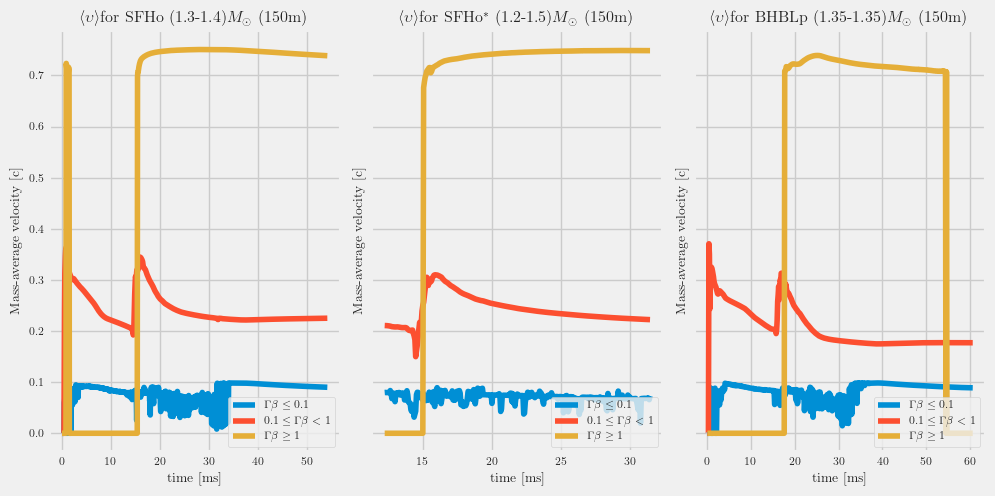

In [25]:
# Plot velocities
def plot_mdot_vave(sim_dics : [dict]):
    fig, axes = plt.subplots(ncols=len(sim_dics),nrows=1,sharey="all",figsize=(10,5))
    
    for i, sim_dic in enumerate(sim_dics):
        data = PBA.id_kenta.Data(fpath_rhomax=sim_dic["datadir"]+sim_dic["rhomax"],
                                 fpath_mdot=sim_dic["datadir"]+sim_dic["mdot_extract"])
        df = data.df_mdot
        ax = axes[i]
        ax.plot(df["time"], df[f"vave_slow"],color=color_pal[0],label=r"$\Gamma\beta \leq 0.1$")
        ax.plot(df["time"], df[f"vave_mid"],color=color_pal[1],label=r'$0.1 \leq \Gamma\beta < 1$')
        ax.plot(df["time"], df[f"vave_fast"],color=color_pal[2],label=r'$\Gamma\beta \geq 1$')
        # ax.set_yscale("log")
        ax.legend()
        ax.set_xlabel("time [ms]")
        ax.set_ylabel("Mass-average velocity [c]")
        # ax.set_ylim(1e-9,1e-2)
        ax.legend(loc='lower right')
        ax.set_title(r"$\langle \upsilon \rangle$"+f" for {sim_dic['label']}")
    
    plt.tight_layout()
    plt.savefig(figs+f"vave.png",dpi=256)
    plt.show()
plot_mdot_vave(sim_dics=[SIMULATIONS["SFHo_13_14_res150"],
                         SIMULATIONS["SFHo_12_15_res150_B15_HLLD"],
                         SIMULATIONS["BHBLp_135_135_res150"]])

In [27]:
# Definition of a retarded time for ejecta mass flux
def get_tret(r : float, vinf_ave0 : float =.7) -> float:
    vinf_ave0 = .7
    return (r*1000.*100./vinf_ave0/PBA.utils.cgs.c) * 1e3 # ms
def get_tret_arr(r : float, vinf_ave0 : np.ndarray) -> np.ndarray:
    vinf_ave0 = .7
    return (r*1000.*100./vinf_ave0/PBA.utils.cgs.c) * 1e3 # ms

[  24   48  144  481 1444 1926 4816  592]
[  24   48  144  481 1444 1926 4816  592]
[  24   48  144  481 1444 1926 4816  592]


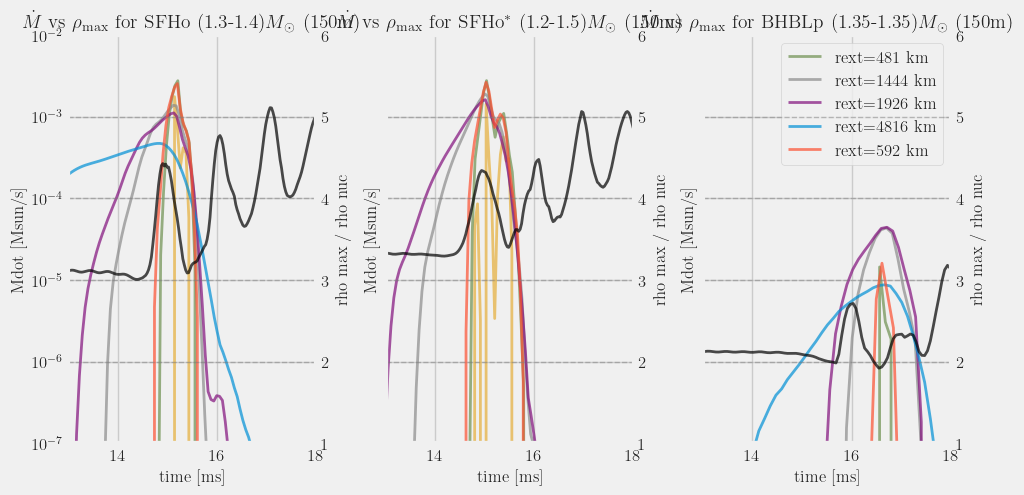

In [44]:
def plot_rho_mdot_rext(sim_dics:list[dict], ylim=(1e-7, 1e-2), ylim2=(1, 6), xlim=(13, 18)) -> None:
    fig, axes = plt.subplots(ncols=len(sim_dics), nrows=1, figsize=(10,5), sharey='all')
    for i, sim_dic in enumerate(sim_dics):


        data = PBA.id_kenta.Data(fpath_rhomax=sim_dic["datadir"]+sim_dic["rhomax"],
                                 fpath_mdot=sim_dic["datadir"]+sim_dic["mdot_extract"])
        rext = data.get_rext()
        print(rext)
        
    
        time = data.df_mdot["time"]
        color_pal = sns.color_palette(n_colors=len(rext))

        ax = axes[i]
        for i, r in enumerate(rext):
            tret = get_tret(r=r) # ms
            tret = get_tret_arr(r=r,vinf_ave0=data.df_mdot[f"vave_fast"]) # ms
            if np.sum(data.df_mdot[f"mdot_fast_r{r}"]) > 0:
                ax.plot(time - tret, data.df_mdot[f"mdot_fast_r{r}"], 
                        color=color_pal[i], label=f"rext={r} km",lw=2,alpha=.7)
    
        # for i, r in enumerate(rext):
            # ax.plot(data.df_mdot["time"], data.df_mdot[f"mdot_fast_r{r}"],color=color_pal[i])
            # ax.plot(data.ret_time(r0=r,vave_key="vave_fast"), data.df_mdot[f"mdot_fast_r{r}"],color=color_pal[i])
            # df.plot("time",f"mdot_fast_r{r}",ax=ax,color=color_pal[i])
        
        
        ax2 = ax.twinx()
        ax2.plot(data.df_rho["time"], data.df_rho[f"rho_max"],color='black',lw=2,alpha=.7)
    
        # df.plot("time",f"rho_max",ax=ax2,color="black")
    
        ax.set_xlabel("time [ms]", fontsize=12)
        ax.set_ylabel("Mdot [Msun/s]", fontsize=12)
        ax2.set_ylabel("rho max / rho nuc", fontsize=12)
        ax.set_yscale("log")
        # ax2.set_yscale("log")
        # ax.grid(color='black')
        ax2.grid(color='gray',ls='--',alpha=.5)
        ax2.tick_params(labelsize=12)
        # ax.legend(loc='lower right', fontsize=12)
        ax.tick_params(labelsize=12)
        if len(ylim) > 0 : ax.set_ylim(*ylim)
        if len(ylim2) > 0 : ax2.set_ylim(*ylim2)
        if len(xlim) > 0 : ax.set_xlim(*xlim)
        ax.set_title(r"$\dot{M}$ vs $\rho_{\rm max}$" + f" for {sim_dic['label']}", fontsize=14)
    axes[-1].legend(loc='upper right', fontsize=12)
    plt.tight_layout()
    plt.savefig(figs+"mdot_rhomax.png",dpi=256)
    plt.show()
    
    # data.df_mdot.plot("time","mdot_fast_r48")
    # data.df_mdot.plot("time","mdot_fast_r144")
    # data.df_mdot.plot("time","mdot_fast_r482")
    # data.df_mdot.plot("time","mdot_fast_r144")
plot_rho_mdot_rext([SIMULATIONS["SFHo_13_14_res150"],
                    SIMULATIONS["SFHo_12_15_res150_B15_HLLD"],
                    SIMULATIONS["BHBLp_135_135_res150"]])

/home/vsevolod/anaconda3/envs/PyBlastAfterglow/lib/python3.9/site-packages/PyBlastAfterglowMag/utils.py:51: RuntimeWarning: invalid value encountered in sqrt
  get_Gamma = lambda beta: np.float64(np.sqrt(1. / (1. - np.float64(beta) ** 2.)))
/home/vsevolod/anaconda3/envs/PyBlastAfterglow/lib/python3.9/site-packages/PyBlastAfterglowMag/utils.py:51: RuntimeWarning: invalid value encountered in sqrt
  get_Gamma = lambda beta: np.float64(np.sqrt(1. / (1. - np.float64(beta) ** 2.)))
/home/vsevolod/anaconda3/envs/PyBlastAfterglow/lib/python3.9/site-packages/PyBlastAfterglowMag/utils.py:51: RuntimeWarning: invalid value encountered in sqrt
  get_Gamma = lambda beta: np.float64(np.sqrt(1. / (1. - np.float64(beta) ** 2.)))


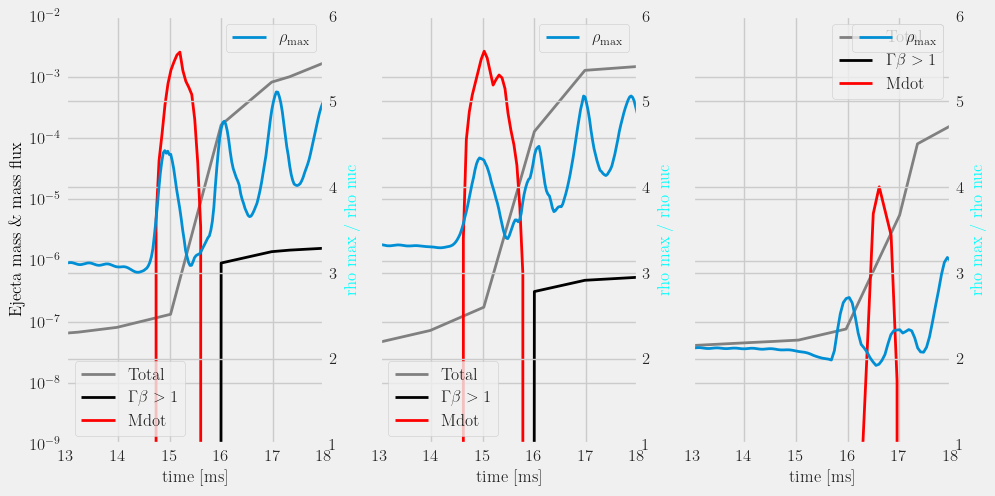

In [45]:
# print(data.get_rext())
def plot_mass_mdot_rho(sim_dics : list[dict], r=592, ylim=(1e-9, 1e-2), ylim2=(1,6), xlim=(13, 18)) -> None:
    fig, axes = plt.subplots(ncols=len(sim_dics), nrows=1, sharey="all", figsize=(10,5))
    for i, sim_dic in enumerate(sim_dics):
        
        ej_data = PBA.id_kenta.EjectaData(sim_dic["datadir"]+"ej_collated.h5",verbose=True)
        data = PBA.id_kenta.Data(fpath_rhomax=sim_dic["datadir"]+sim_dic["rhomax"],
                                 fpath_mdot=sim_dic["datadir"]+sim_dic["mdot_extract"])
        
        tret = get_tret(r=r) # ms
        tret = get_tret_arr(r=r,vinf_ave0=data.df_mdot[f"vave_fast"]) # ms
    
        ax = axes[i]
        ax.plot(ej_data.getText(), ej_data.total_mass(), color="gray",label="Total", lw=2)
        ax.plot(ej_data.getText(), ej_data.total_mass_vs_text(crit="fast"),color="black",label=r"$\Gamma\beta>1$", lw=2)
        
        ax.plot(data.df_mdot["time"] - tret, data.df_mdot[f"mdot_fast_r{r}"],color="red", label=f"Mdot", lw=2)
        
        if len(ylim) > 0: ax.set_ylim(*ylim)
        ax.set_yscale("log")
        
        ax2 = ax.twinx()
        ax2.plot(data.df_rho["time"], data.df_rho[f"rho_max"],label=r"$\rho_{\rm max}$", lw=2)  
        # data.df_rho.plot("time","rho_max",ax=ax2,color="green",label=r"$\rho_{\rm max}$")
        # data.df_mdot.plot("time","mdot_r481",ax=ax2,color="pink",label=r"$\dot{M}_{\rm ej}$")
        ax.set_yscale("log")
        ax.set_xlim(10,30)
        ax.set_xlabel("time [ms]",fontsize=12)
        # ax.set_ylabel("Ejecta mass \& mass flux", color="black",fontsize=12)
        ax2.set_ylabel("rho max / rho nuc", color="cyan",fontsize=12)
        ax.legend(fontsize=12)
        ax.tick_params(labelsize=12)
        ax2.tick_params(labelsize=12)
        ax2.legend(fontsize=12)
        if len(ylim2) > 0: ax2.set_ylim(*ylim2)
        if len(ylim) > 0: ax.set_ylim(*ylim)
        if len(xlim) > 0 : ax.set_xlim(*xlim)
        # ax.set_title()
    axes[0].set_ylabel("Ejecta mass \& mass flux", color="black",fontsize=12)
    plt.tight_layout()
    plt.savefig(figs+f"mdot_mej_rhomax.png",dpi=256)
    plt.show()
plot_mass_mdot_rho([SIMULATIONS["SFHo_13_14_res150"],
                    SIMULATIONS["SFHo_12_15_res150_B15_HLLD"],
                    SIMULATIONS["BHBLp_135_135_res150"]])

In [48]:
# Sumamry
def print_summary(sim_dics:list[dict]):
    for sim_dic in sim_dics:
        
        data = PBA.id_kenta.EjectaData(sim_dic["datadir"]+"ej_collated.h5",verbose=True)
        # data = PBA.id_kenta.Data(fpath_rhomax=sim_dic["datadir"]+sim_dic["rhomax"],
        #                          fpath_mdot=sim_dic["datadir"]+sim_dic["mdot_extract"])
        print("-"*10+sim_dic["label"]+"-"*10)
        max_mass = np.max(data.total_mass_vs_text(crit="fast"))
        text_max_mass = data.getText()[np.argmax(data.total_mass_vs_text(crit="fast"))]
    
        print(f"Maximum fast of the fast tail: {max_mass:.2e} Msun at extraction time {text_max_mass:.1f} ms")
    
        ej_mass = data.get(v_n="mass",text=text_max_mass)
        ej_vinf = data.get_vinf()
        mask = data.get_vinf_mask(crit="fast")
        vave = np.sum(ej_mass[:,mask]*ej_vinf[mask])/np.sum(ej_mass[:,mask])
        print(f"Mass-averaged velocity of the fast tail at this extraction time: {vave:.2f} c")
    
        thetas = data.get_theta()
        theta_rms = (180. / np.pi) * np.sqrt(np.sum(np.sum(ej_mass[:,mask], axis=1) * thetas ** 2) / np.sum(ej_mass[:,mask]))
        print(f"theta_rms of the fast of the fast tail at this extraction time: {theta_rms:.2f} deg")
print_summary(sim_dics=[SIMULATIONS["SFHo_13_14_res150"],
                        SIMULATIONS["SFHo_12_15_res150_B15_HLLD"],
                        SIMULATIONS["BHBLp_135_135_res150"]])

----------SFHo (1.3-1.4)$M_{\odot}$ (150m)----------
Maximum fast of the fast tail: 2.01e-06 Msun at extraction time 41.0 ms
Mass-averaged velocity of the fast tail at this extraction time: 0.74 c
theta_rms of the fast of the fast tail at this extraction time: 62.06 deg
----------SFHo$^*$ (1.2-1.5)$M_{\odot}$ (150m)----------
Maximum fast of the fast tail: 6.60e-07 Msun at extraction time 31.0 ms
Mass-averaged velocity of the fast tail at this extraction time: 0.75 c
theta_rms of the fast of the fast tail at this extraction time: 67.56 deg
----------BHBLp (1.35-1.35)$M_{\odot}$ (150m)----------
Maximum fast of the fast tail: 8.18e-08 Msun at extraction time 29.0 ms
Mass-averaged velocity of the fast tail at this extraction time: 0.73 c
theta_rms of the fast of the fast tail at this extraction time: 60.46 deg


/home/vsevolod/anaconda3/envs/PyBlastAfterglow/lib/python3.9/site-packages/PyBlastAfterglowMag/utils.py:51: RuntimeWarning: invalid value encountered in sqrt
  get_Gamma = lambda beta: np.float64(np.sqrt(1. / (1. - np.float64(beta) ** 2.)))


In [101]:
# Collate new Mdot Files (USE ONLY ONCE)
#ej = ProcessRaw(simumlation = SIMULATIONS["SFHo_12_15_res150_B15_HLLD"])
#ej.process_raw_ejecta_files(infiles="Mdot_ejecta_*.h5", fname_output="mdot_ej_collated.h5", mode="mdot",overwrite=True)

In [102]:
# Load Mdot
# mdot_ej = PBA.id_kenta.EjectaData(sim_dic["datadir"]+"mdot_ej_collated.h5",verbose=True,mode="mdot")

In [103]:
# ext_radii = mdot_ej.get_rext()
# ext_text = mdot_ej.getText()
# theta = mdot_ej.get_theta()
# mdot_example = mdot_ej.get(v_n="mdot_fast",text=ext_text[3])
# print(f"Extraction Radii shape={ext_radii.shape} ", ext_radii)
# print(f"Extraction times shape={ext_text.shape} ", ext_text)
# print(f"Mdot.shape()={mdot_example.shape}")
# print(f"theta={theta.shape}", theta)

Extraction Radii shape=(8,)  [  24.08   48.17  144.5   481.67  592.12 1445.01 1926.68 4816.71]
Extraction times shape=(66,)  [2.88e-02 1.01e+00 1.99e+00 3.03e+00 4.01e+00 4.47e+00 4.99e+00 6.02e+00
 7.00e+00 7.98e+00 8.79e+00 9.02e+00 1.00e+01 1.10e+01 1.20e+01 1.30e+01
 1.32e+01 1.40e+01 1.50e+01 1.60e+01 1.70e+01 1.73e+01 1.80e+01 1.90e+01
 2.00e+01 2.10e+01 2.13e+01 2.20e+01 2.30e+01 2.40e+01 2.50e+01 2.53e+01
 2.60e+01 2.63e+01 2.70e+01 2.73e+01 2.80e+01 2.83e+01 2.90e+01 2.93e+01
 3.00e+01 3.02e+01 3.10e+01 3.20e+01 3.30e+01 3.39e+01 3.40e+01 3.50e+01
 3.60e+01 3.70e+01 3.76e+01 3.80e+01 3.90e+01 4.00e+01 4.10e+01 4.17e+01
 4.20e+01 4.30e+01 4.40e+01 4.50e+01 4.59e+01 4.60e+01 4.70e+01 4.80e+01
 4.90e+01 4.99e+01]
Mdot.shape()=(65, 8)
theta=(65,) [0.01 0.04 0.06 0.09 0.11 0.13 0.16 0.18 0.21 0.23 0.26 0.28 0.31 0.33
 0.36 0.38 0.4  0.43 0.45 0.48 0.5  0.53 0.55 0.58 0.6  0.63 0.65 0.67
 0.7  0.72 0.75 0.77 0.8  0.82 0.85 0.87 0.9  0.92 0.94 0.97 0.99 1.02
 1.04 1.07 1.09 1.12 1.14

0.1305936761200428


/home/vsevolod/anaconda3/envs/PyBlastAfterglow/lib/python3.9/site-packages/PyBlastAfterglowMag/utils.py:51: RuntimeWarning: invalid value encountered in sqrt
  get_Gamma = lambda beta: np.float64(np.sqrt(1. / (1. - np.float64(beta) ** 2.)))
/tmp/ipykernel_189584/3274549349.py:8: RuntimeWarning: invalid value encountered in double_scalars
  vave[it] = np.sum(ej_mass[:,mask]*ej_vinf[mask])/np.sum(ej_mass[:,mask])
/tmp/ipykernel_189584/3274549349.py:11: RuntimeWarning: invalid value encountered in double_scalars
  theta_rms[it] = (180. / np.pi) * np.sqrt(np.sum(np.sum(ej_mass[:,mask], axis=1) * thetas ** 2) / np.sum(ej_mass[:,mask]))


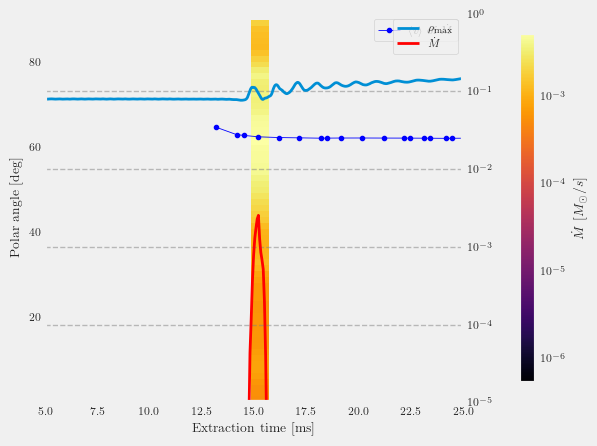

0.04253199113031769


/home/vsevolod/anaconda3/envs/PyBlastAfterglow/lib/python3.9/site-packages/PyBlastAfterglowMag/utils.py:51: RuntimeWarning: invalid value encountered in sqrt
  get_Gamma = lambda beta: np.float64(np.sqrt(1. / (1. - np.float64(beta) ** 2.)))
/tmp/ipykernel_189584/3274549349.py:8: RuntimeWarning: invalid value encountered in double_scalars
  vave[it] = np.sum(ej_mass[:,mask]*ej_vinf[mask])/np.sum(ej_mass[:,mask])
/tmp/ipykernel_189584/3274549349.py:11: RuntimeWarning: invalid value encountered in double_scalars
  theta_rms[it] = (180. / np.pi) * np.sqrt(np.sum(np.sum(ej_mass[:,mask], axis=1) * thetas ** 2) / np.sum(ej_mass[:,mask]))


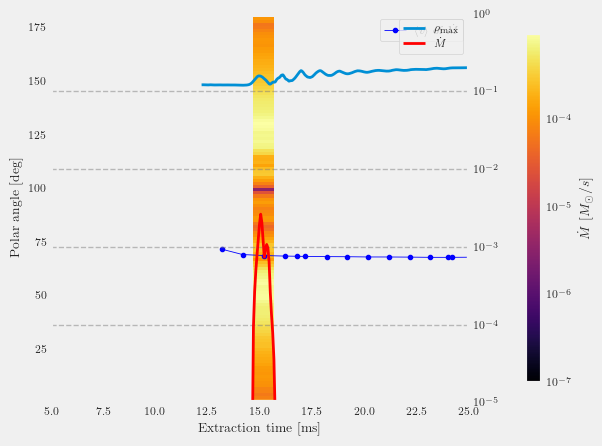

259.1664870926715


/home/vsevolod/anaconda3/envs/PyBlastAfterglow/lib/python3.9/site-packages/PyBlastAfterglowMag/utils.py:51: RuntimeWarning: invalid value encountered in sqrt
  get_Gamma = lambda beta: np.float64(np.sqrt(1. / (1. - np.float64(beta) ** 2.)))
/tmp/ipykernel_189584/3274549349.py:8: RuntimeWarning: invalid value encountered in double_scalars
  vave[it] = np.sum(ej_mass[:,mask]*ej_vinf[mask])/np.sum(ej_mass[:,mask])
/tmp/ipykernel_189584/3274549349.py:11: RuntimeWarning: invalid value encountered in double_scalars
  theta_rms[it] = (180. / np.pi) * np.sqrt(np.sum(np.sum(ej_mass[:,mask], axis=1) * thetas ** 2) / np.sum(ej_mass[:,mask]))


ValueError: x and y must have same first dimension, but have shapes (88,) and (56,)

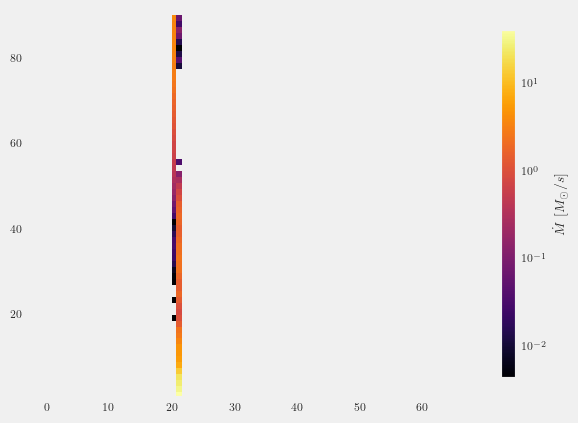

In [56]:
# plot Mdot for different thetas
# print(mdot_ej.get_theta())
# print(mdot_ej.get_rext())
# print(mdot_ej.getText())
# print(mdot_ej.get(v_n="mdot_fast",text=20))

def plot_mdot(text=24) -> None:
    fig, ax = plt.subplots(ncols=1, nrows=1)
    for t in mdot_ej.getText():
        vals = mdot_ej.get(v_n="mdot_fast",text=t).T
        print(f"t={t} sum_mdot={np.sum(vals)}")

    vals = mdot_ej.get(v_n="mdot_fast",text=text).T
    vals[np.isnan(vals)] = 0.
    vals = np.log10(vals)
    rext = mdot_ej.get_rext()
    print(np.sum(vals))
    print(mdot_ej.get_theta())
    print(mdot_ej.get_rext())
    #ax.imshow(vals,aspect=6)
    ax.pcolormesh(
        mdot_ej.get_rext(),
        mdot_ej.get_theta(),
        vals.T,
        cmap="inferno",
        # norm=LogNorm()
    )
    plt.show()
def plot_mdot2(sim_dic: dict, rext=592, key="mid") -> None:

    data = PBA.id_kenta.Data(fpath_rhomax=sim_dic["datadir"]+sim_dic["rhomax"],
                             fpath_mdot=sim_dic["datadir"]+sim_dic["mdot_extract"])
    ej_data = PBA.id_kenta.EjectaData(sim_dic["datadir"]+"ej_collated.h5",verbose=True)
    mdot_ej = PBA.id_kenta.EjectaData(sim_dic["datadir"]+"mdot_ej_collated.h5",verbose=True,mode="mdot")

    ext_text = mdot_ej.getText()
    ext_radii = mdot_ej.get_rext()

    mdot_example = mdot_ej.get(v_n=f"mdot_{key}",text=ext_text[3])
    print(f"Extraction Radii shape={ext_radii.shape} ", ext_radii)
    print(f"Extraction times shape={ext_text.shape} ", ext_text)
    print(f"Mdot.shape()={mdot_example.shape}")
    print(f"theta={theta.shape}", theta)
        
    fig, ax = plt.subplots(ncols=1, nrows=1)
    # for t in mdot_ej.getText():
    #     vals = mdot_ej.get(v_n="mdot_fast",text=t).T
    #     print(f"t={t} sum_mdot={np.sum(vals)}")
    vals = np.zeros((len(mdot_ej.getText()),
                     len(mdot_ej.get_theta())))
    
    for it, t in enumerate(ext_text):
        _vals = mdot_ej.get(v_n="mdot_"+key,text=t).T
        idx = PBA.utils.find_nearest_index(ext_radii, rext)
        vals[it, :] = _vals[idx,:]
        
    vals[np.isnan(vals)] = 0.
    # vals = np.log10(vals)
    print(np.sum(vals))

    #ax.imshow(vals,aspect=6)
    tret = get_tret_arr(r=rext,vinf_ave0=data.df_mdot[f"vave_"+key]) # ms

    norm = LogNorm(vmin=vals.max() * 1e-4, vmax=vals.max())
    _c = ax.pcolormesh(
        ext_text-tret,
        mdot_ej.get_theta() * 180 / np.pi,
        vals.T,
        cmap="inferno",
        norm=norm
    )
    fig.colorbar(_c, ax=ax,shrink=0.9,pad=.1,label=r"$\dot{M}$ $[M_{\odot}/s]$")

    vave, theta_rms = get_vave_theta_rms(ej=ej_data, crit=key)

    # ax[1].plot(ext_text, vave, color=color_pal[idx], marker='.', lw=.6)
    ax.plot(ext_text - tret, theta_rms, color="blue", marker='.', lw=.6,label=r"$\langle v \rangle$ of $\dot{M}$")

    ax.set_ylabel("Polar angle [deg]")
    ax.set_xlabel("Extraction time [ms]")
    ax.legend()
    
    ax2 = ax.twinx()
    ax2.plot(data.df_rho["time"], data.df_rho[f"rho_max"]/data.df_rho[f"rho_max"].max(),label=r"$\rho_{\rm max}$", lw=2)
    ax2.plot(data.df_mdot["time"] - tret, data.df_mdot[f"mdot_{key}_r{rext}"],color="red", lw=2,
             label=r"$\dot{M}$")
    ax2.set_ylim(1e-5,1e0)
    ax2.set_yscale("log")
    ax2.legend()
    ax2.grid(color='gray',ls='--',alpha=.5)
    
    ax.set_xlim(5,25)
    plt.show()    
# plot_mdot()
plot_mdot2(sim_dic=SIMULATIONS["SFHo_13_14_res150"], rext=592, key="fast")
plot_mdot2(sim_dic=SIMULATIONS["SFHo_12_15_res150_B15_HLLD"], rext=592, key="fast")
plot_mdot2(sim_dic=SIMULATIONS["BHBLp_135_135_res150"], rext=592, key="fast")

def plot_rho_mdot_rext_mdot_ej() -> None:
    rext = data.get_rext()
    fig, ax = plt.subplots(ncols=1,nrows=1)

    time = data.df_mdot["time"]

    for i, r in enumerate(rext):
        tret = get_tret(r=r) # ms
        tret = get_tret_arr(r=r,vinf_ave0=data.df_mdot[f"vave_fast"]) # ms
        if np.sum(data.df_mdot[f"mdot_fast_r{r}"]) > 0:
            ax.plot(time - tret, data.df_mdot[f"mdot_fast_r{r}"],color=color_pal[i], label=f"rext={r} km",lw=2,alpha=.7)

    # for i, r in enumerate(rext):
        # ax.plot(data.df_mdot["time"], data.df_mdot[f"mdot_fast_r{r}"],color=color_pal[i])
        # ax.plot(data.ret_time(r0=r,vave_key="vave_fast"), data.df_mdot[f"mdot_fast_r{r}"],color=color_pal[i])
        # df.plot("time",f"mdot_fast_r{r}",ax=ax,color=color_pal[i])

    ax2 = ax.twinx()
    ax2.plot(data.df_rho["time"], data.df_rho[f"rho_max"],color='black',lw=2,alpha=.7)

    # df.plot("time",f"rho_max",ax=ax2,color="black")

    ax.set_xlabel("time [ms]", fontsize=12)
    ax.set_ylabel("Mdot [Msun/s]", fontsize=12)
    ax2.set_ylabel("rho max / rho nuc", fontsize=12)
    ax.set_yscale("log")
    # ax2.set_yscale("log")
    # ax.grid(color='black')
    ax2.grid(color='gray',ls='--',alpha=.5)
    ax2.tick_params(labelsize=12)
    ax.set_xlim(10,25)
    ax.legend(loc='lower right', fontsize=12)
    ax.tick_params(labelsize=12)
    plt.title(f"Mdot vs rho_max for {sim_dic['label']}", fontsize=14)
    plt.tight_layout()
    plt.savefig(figs+"mdot_rhomax_{sim_dic['name']}.png",dpi=256)
    plt.show()
    
    # data.df_mdot.plot("time","mdot_fast_r48")
    # data.df_mdot.plot("time","mdot_fast_r144")
    # data.df_mdot.plot("time","mdot_fast_r482")
    # data.df_mdot.plot("time","mdot_fast_r144")


|# ONE SIMULATION: SFHo q=1.25 (150m)